In [1]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
path = os.path.dirname(os.getcwd())
# path = os.path.dirname(path)
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

- 지역 별 등록차량수 평균값에 세대당_인구 곱해서 변수 생성

In [3]:
reg = train.groupby("지역").mean()["등록차량수"].reset_index()
train= pd.merge(train, reg, on="지역", how="left")
train= train.rename(columns={'등록차량수_x':'등록차량수', '등록차량수_y':'지역별 등록차량수'})
train["지역x세대당인구"] =  train["지역별 등록차량수"]*train['세대당_인구']
test= pd.merge(test, reg, on="지역", how="left")
test= test.rename(columns={'등록차량수':'지역별 등록차량수'})
test["지역x세대당인구"]= test["지역별 등록차량수"]*test["세대당_인구"]

- 상가 데이터는 제거

In [4]:
train = train[train['임대건물구분']=='아파트']
test = test[test['임대건물구분']=='아파트']

- 환승역 수 : 해당 아파트에서 가장 가까운 지하철 역의 정보
- 특정 아파트에서 10분 내에 지하철이 없는 지역의 경우 환승역 수를 모두 0으로 바꿔줌

In [5]:
area = ['경상남도', '전라북도', '강원도', '광주광역시', '충청남도', '제주특별자치도', '울산광역시', '충청북도', '전라남도', '경상북도', '세종특별자치시']
for ind in range(train.shape[0]):
    if train.loc[ind,'지역'] in area :
        train.loc[ind,'환승역 수'] = 0

In [6]:
area = ['경상남도', '전라북도', '강원도', '광주광역시', '충청남도', '제주특별자치도', '울산광역시', '충청북도', '전라남도', '경상북도', '세종특별자치시']
for ind in range(test.shape[0]):
    if test.loc[ind,'지역'] in area :
        test.loc[ind,'환승역 수'] = 0

In [7]:
train['공가비율'] = train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['공가비율'] = test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)

In [8]:
train['0~19 인구수'] = train['0~19세_비율']*train['총세대수']
train['20~39 인구수'] = train['20~39세_비율']*train['총세대수']
train['40~69 인구수'] = train['40~69세_비율']*train['총세대수']
train['70세이상 인구수'] = train['70세이상_비율']*train['총세대수']

test['0~19 인구수'] = test['0~19세_비율']*test['총세대수']
test['20~39 인구수'] = test['20~39세_비율']*test['총세대수']
test['40~69 인구수'] = test['40~69세_비율']*test['총세대수']
test['70세이상 인구수'] = test['70세이상_비율']*test['총세대수']

- 전용면적이 20대인 경우 모두 25로 통일

In [9]:
def func(x):
    for i in range(10,90,10):
        if int(x) in range(i,i+10):
            return i+5

train['전용면적'] = train['전용면적'].apply(lambda x : func(x))
test['전용면적'] = test['전용면적'].apply(lambda x : func(x))

In [10]:
train = train.join(pd.get_dummies(train['공급유형']))
test = test.join(pd.get_dummies(test['공급유형']))
test['공공분양'] = 0
test['공공임대(5년)'] = 0 
test['장기전세'] = 0

In [11]:
not_unique = ['자격유형','임대보증금','임대료','전용면적별세대수','전용면적','공급유형']

- 단지코드, 전용면적, 공급유형을 기준으로 데이터 일차원으로 병합
- 아파트 별로 일차원 병합하지 않은 이유: 면적 별로 (20,30) 임대료, 임대보증금의 차이가 커서 단순 평균내는 것은 정보손실 우려가 있음
- 병합하는 과정에서 임대료/임대보증금 평균
- y값은 등록차량수 $\rightarrow$ 등록차량수/단지내주차면수로 바꿔줌 $\because$ 단지내주차면수와 y값 간의 correlation이 큼
- 단지내주차면수, 등록차량수는 전용면적별세대수/아파트전체세대수 비율을 곱해서 변수 생성

In [12]:
tmp1 = train.drop(not_unique,axis=1).drop_duplicates()

tmp = pd.DataFrame(train.groupby(['단지코드','전용면적','공급유형']).sum()['전용면적별세대수']).reset_index()
tmp = pd.merge(tmp,tmp1.drop_duplicates(),on='단지코드',how='left')
total = pd.DataFrame(tmp.groupby('단지코드').sum()['전용면적별세대수']).reset_index(drop=False).rename(columns={'전용면적별세대수':'total'})
tmp = pd.merge(tmp,total,on='단지코드',how='left')
tmp['ratio'] = tmp.apply(lambda x : x['전용면적별세대수']/x['total'],axis=1)
tmp['y1'] = tmp.apply(lambda x : x['ratio']*x['등록차량수'],axis=1)

total = pd.DataFrame(train.groupby(['단지코드','전용면적','공급유형']).mean()['임대료']).reset_index()
tmp = pd.merge(tmp,total,on=['단지코드','전용면적','공급유형'],how='left')

total = pd.DataFrame(train.groupby(['단지코드','전용면적','공급유형']).mean()['임대보증금']).reset_index()
tmp = pd.merge(tmp,total,on=['단지코드','전용면적','공급유형'],how='left')

tmp['단지내주차면수_new'] = tmp.apply(lambda x : x['단지내주차면수']*x['ratio'],axis=1)
tmp = tmp.drop(['ratio'],axis=1)

train = tmp
train['y2'] = train.apply(lambda x : x['y1']/x['단지내주차면수_new'],axis=1)

In [13]:
tmp1 = test.drop(not_unique,axis=1).drop_duplicates()

tmp = pd.DataFrame(test.groupby(['단지코드','전용면적','공급유형']).sum()['전용면적별세대수']).reset_index()
tmp = pd.merge(tmp,tmp1.drop_duplicates(),on='단지코드',how='left')
total = pd.DataFrame(tmp.groupby('단지코드').sum()['전용면적별세대수']).reset_index(drop=False).rename(columns={'전용면적별세대수':'total'})
tmp = pd.merge(tmp,total,on='단지코드',how='left')
tmp['ratio'] = tmp.apply(lambda x : x['전용면적별세대수']/x['total'],axis=1)

total = pd.DataFrame(test.groupby(['단지코드','전용면적','공급유형']).mean()['임대료']).reset_index()
tmp = pd.merge(tmp,total,on=['단지코드','전용면적','공급유형'],how='left')

total = pd.DataFrame(test.groupby(['단지코드','전용면적','공급유형']).mean()['임대보증금']).reset_index()
tmp = pd.merge(tmp,total,on=['단지코드','전용면적','공급유형'],how='left')

tmp['단지내주차면수_new'] = tmp.apply(lambda x : x['단지내주차면수']*x['ratio'],axis=1)
tmp = tmp.drop(['ratio'],axis=1)

test = tmp

In [14]:
train['0~19 인구수'] = train['0~19세_비율']*train['전용면적별세대수']
train['20~39 인구수'] = train['20~39세_비율']*train['전용면적별세대수']
train['40~69 인구수'] = train['40~69세_비율']*train['전용면적별세대수']
train['70세이상 인구수'] = train['70세이상_비율']*train['전용면적별세대수']

test['0~19 인구수'] = test['0~19세_비율']*test['전용면적별세대수']
test['20~39 인구수'] = test['20~39세_비율']*test['전용면적별세대수']
test['40~69 인구수'] = test['40~69세_비율']*test['전용면적별세대수']
test['70세이상 인구수'] = test['70세이상_비율']*test['전용면적별세대수']

col = ['0~19세_비율','20~39세_비율','40~69세_비율','70세이상_비율']
train = train.drop(col,axis=1)
test = test.drop(col,axis=1)

In [15]:
train.corr()['y2']

전용면적           0.272737
전용면적별세대수      -0.072524
총세대수          -0.145421
공가수           -0.265737
지하철역          -0.063657
버스정류장          0.036348
단지내주차면수       -0.050276
등록차량수          0.363013
연면적            0.005723
위도            -0.041786
경도             0.083341
subway_dist   -0.000263
환승역 수         -0.039037
총인구수          -0.082692
세대당_인구         0.039506
남/여비율          0.006577
남/여_0~19세     -0.020200
남/여_20~39세     0.015812
남/여_40~69세    -0.022726
남/여_70세이상      0.016666
지역별 등록차량수      0.116235
지역x세대당인구       0.110623
공가비율          -0.099302
0~19 인구수      -0.050625
20~39 인구수     -0.067115
40~69 인구수     -0.074199
70세이상 인구수     -0.084072
공공분양           0.083793
공공임대(10년)      0.270612
공공임대(50년)      0.138447
공공임대(5년)       0.028804
공공임대(분납)       0.060542
국민임대          -0.060507
영구임대          -0.148812
장기전세           0.002327
행복주택          -0.074147
total         -0.013923
y1             0.300276
임대료            0.273141
임대보증금          0.084868
단지내주차면수_new   -0.004911
y2             1

<AxesSubplot:xlabel='y2', ylabel='Count'>

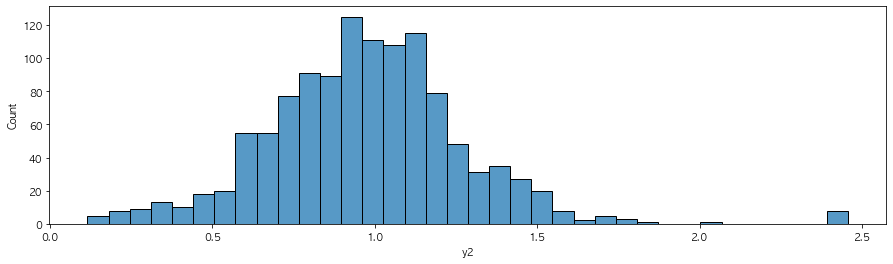

In [16]:
fig,ax = plt.subplots(figsize=(15,4))
sns.histplot(train['y2'])

- 이상치제거

In [17]:
train = train[train['단지코드']!='C1722']
train = train.reset_index(drop=True)

<AxesSubplot:xlabel='y2', ylabel='Count'>

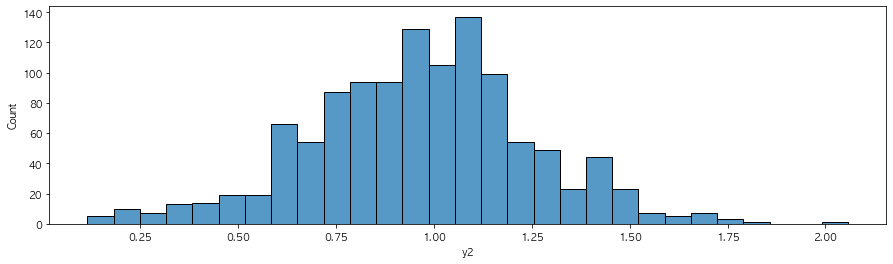

In [18]:
fig,ax = plt.subplots(figsize=(15,4))
sns.histplot(train['y2'])

In [19]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor 
from catboost import CatBoostRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
#from pycaret.regression import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from sklearn import preprocessing

In [20]:
code = pd.DataFrame()
code['단지코드'] = train['단지코드'].unique()
code = code.reset_index()
train = pd.merge(train,code,on='단지코드')

In [21]:
model = [CatBoostRegressor(random_state=2021,loss_function='MAE',verbose=False),
            RandomForestRegressor(random_state=2021)]
best = 100000
best_model = None


for j in model:
    s = 0
    print(j)
    for i in [80,160,240,320,400]:
        X = train[-train['index'].isin(range(i-80,i))]
        col = ['단지코드','등록차량수','임대건물구분','subway_name','단지명','도로명주소', '연면적','total','지역',
       '단지내주차면수','y1','y2','공급유형', '단지내주차면수_new','index']
        X_train = X.drop(col,axis=1)
        y_train = X['y2']
        X = train[train['index'].isin(range(i-80,i))]
        X_test = X.drop(col,axis=1)
        y_test = X['y2']

        cb = j.fit(X_train,y_train)
        pred = cb.predict(X_test)
        
        X['y2pred'] = pred
        X['y1pred'] = X['단지내주차면수_new']*X['y2pred']
        tmp1 = pd.DataFrame()
        tmp1['단지코드'] = X['단지코드'].unique()
        tmp1['y1'] = X.groupby(['단지코드']).sum()['y1'].tolist()
        tmp1['y1pred'] = X.groupby(['단지코드']).sum()['y1pred'].tolist()
        error = mean_absolute_error(tmp1['y1pred'],tmp1['y1'])
        print(error)
        s += error
    print('----done----')
    print(j,s/5)
    if s/5 < best:
        best_model = j
        best = s/5
print('----result----')
print(best_model,best)

138.88221118929897
114.40140085768203
104.12934923956064
100.73513158058856
125.65849273943941
----done----
<catboost.core.CatBoostRegressor object at 0x7f9fec565790> 116.76131712131394
RandomForestRegressor(random_state=2021)
139.7587076607926
107.91496925009423
104.94349762791776
91.5401627314859
122.59600088613377
----done----
RandomForestRegressor(random_state=2021) 113.35066763128484
----result----
RandomForestRegressor(random_state=2021) 113.35066763128484


In [22]:
col = ['단지코드','등록차량수','임대건물구분','subway_name','단지명','도로명주소',
       '연면적','total','지역','단지내주차면수','y1','y2','공급유형',
       '단지내주차면수_new','index']

In [23]:
X = train[-train['index'].isin(range(0,80))]
col = ['단지코드','등록차량수','임대건물구분','subway_name','단지명','도로명주소',
       '연면적','total','지역','단지내주차면수','y1','y2','공급유형','연면적','단지내주차면수_new','index']
X_train = X.drop(col,axis=1)
y_train = X['y2']
X = train[train['index'].isin(range(0,80))]
X_test = X.drop(col,axis=1)
y_test = X['y2']

rf = RandomForestRegressor(random_state=2021).fit(X_train,y_train)
pred = rf.predict(X_test)

cb = CatBoostRegressor(random_state=2021,loss_function='MAE',verbose=False).fit(X_train,y_train)
pred2 = cb.predict(X_test)

In [24]:
train.shape

(1169, 50)

<AxesSubplot:>

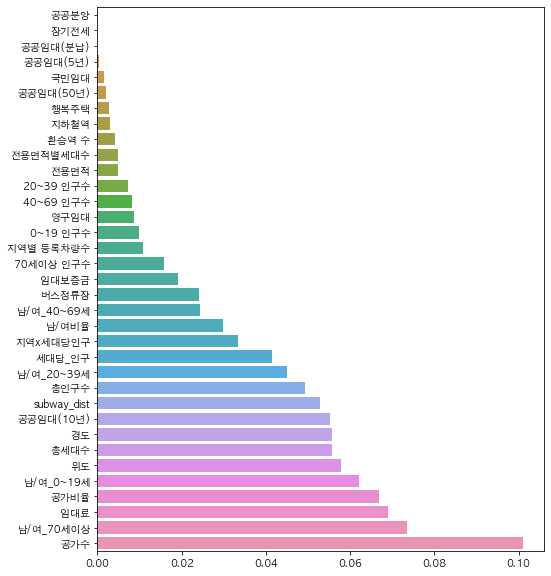

In [25]:
plt.figure(figsize=(8,10))
sns.barplot(y = X_test.columns[np.argsort(rf.feature_importances_)], x = list(rf.feature_importances_[np.argsort(rf.feature_importances_)]))

<AxesSubplot:>

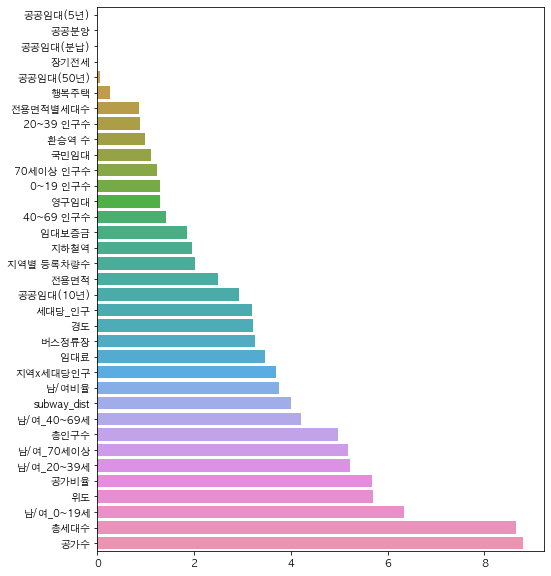

In [26]:
plt.figure(figsize=(8,10))
sns.barplot(y = X_test.columns[np.argsort(cb.feature_importances_)], x = list(cb.feature_importances_[np.argsort(cb.feature_importances_)]))

In [27]:
set(test.columns) - set(train.columns)

set()

In [28]:
col = ['단지코드','등록차량수','임대건물구분','subway_name','단지명','도로명주소',
       '연면적','total','지역','단지내주차면수','y1','y2','공급유형','연면적','단지내주차면수_new','index']
X_train = train.drop(col,axis=1)
y_train = train['y2']
col = ['단지코드','임대건물구분','subway_name','단지명','도로명주소','연면적','total','지역','단지내주차면수','공급유형','연면적','단지내주차면수_new']
X_test = test.drop(col,axis=1)

rf = RandomForestRegressor(random_state=2021).fit(X_train,y_train)
pred = rf.predict(X_test)

cb = CatBoostRegressor(random_state=2021, verbose=False).fit(X_train,y_train) # loss_function='MAE',
pred2 = cb.predict(X_test)

In [29]:
test['y2pred_cb'] = pred2
test['y1pred_cb'] = test['단지내주차면수_new']*test['y2pred_cb']
res = pd.DataFrame()
res['단지코드'] = test['단지코드'].unique()
res['cb'] = test.groupby(['단지코드']).sum()['y1pred_cb'].tolist()

In [30]:
res.head()

,단지코드,cb
0,C1003,236.901719
1,C1006,208.102844
2,C1016,635.110508
3,C1019,259.273206
4,C1030,27.584941


In [31]:
submit = res[['단지코드','cb']]
submit.columns = ['code','num']
submit.loc[147,:] = ['C1327',0]
submit.loc[148,:] = ['C2335',0]
submit.loc[149,:] = ['C2675',0]

In [32]:
submit.to_csv("submit.csv",index=False)